In [25]:
#importing packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [32]:
#Parameters
nX0 = 0.75       # chance of a grid site containing a X cell initially
nM0 = 0.75       # chance of a grid site containing a M cell initially
bx = 0.1 # chance of a X cell dividing per time step if there is space
bm = 0.1 # chance of a M cell dividing per time step if there is space
dx = 0.1 # chance of a X cell death per time step if there is space
dm = 0.2 # chance of a M cell death per time step if there is space
sm = 0.5 # chance of a M cell killing local X cell
sx = 0.5 # chance of a X cell killing local M cell (s>d)
h = 10   # range of long range interaction (in cell number)
lx = 0.2 # rate of M cell appearing at h distance from X


lengthX = 50    # domain width
lengthY = 50    # domain height
numSteps = 100  # number of time steps to simulate



In [27]:
p_zero = 1 - nX0 - nM0  # Probability for 0

# Generate uniform random grid
rand = np.random.random((lengthX, lengthY))

# Initialize grid with zeros
cellGrid = np.zeros((lengthX, lengthY), dtype=int)

# Assign -1 where random < nX0
cellGrid[rand < nX0] = -1

# Assign 1 where random >= nX0 and < (nX0 + nM0)
cellGrid[(rand >= nX0) & (rand < nX0 + nM0)] = 1

# 0 stays as default elsewhere

def plotcells(cellGrid):
    # Create a custom colormap
    colors = ['orange', 'white', 'black']
    cmap = matplotlib.colors.ListedColormap(colors)
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    plt.figure()
    plt.imshow(cellGrid, cmap=cmap, norm=norm)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Initial condition (yellow, white, black = cell)")
    plt.colorbar(ticks=[-1, 0, 1], label='Cell Type (-1: X, 0: Empty, 1: M)')

    return plt.show()



In [28]:
# Exercise 6: Write your function birth_cells here:
def birth_cells(cellGrid):

  global bm, bx, lengthX, lengthY

  # Counting the number of empty cells in the grid
  N = lengthX*lengthY - sum(sum(np.abs(cellGrid)))

  # Identifying the indices of the cells in the grid
  nocellIndices = np.transpose(np.where(cellGrid == 0))
  np.random.shuffle(nocellIndices)

  # For-loop to step through cells
  for nocelli in range(N):

    nocelli_indices = nocellIndices[nocelli,:]

    # Generating random number to determine if division will be attempted
    chanceForCelli = np.random.uniform(0, 1,size=1)

    # which cell to produce
    if chanceForCelli < bx:
      cellGrid[nocelli_indices[0],nocelli_indices[1]] = -1
    elif chanceForCelli < (bx+bm):
      cellGrid[nocelli_indices[0],nocelli_indices[1]] = 1
    else:
      cellGrid[nocelli_indices[0],nocelli_indices[1]] = 0

  return cellGrid

In [29]:
# Exercise 6: Write your function death_cells here:
def death_cells(cellGrid):

  global dm, dx, lengthX, lengthY

  # Counting the number of cells in the grid
  N = sum(sum(np.abs(cellGrid)))

  # Identifying the indices of the cells in the grid
  cellIndices = np.transpose(np.nonzero(cellGrid))
  np.random.shuffle(cellIndices)

  # For-loop to step through cells
  for celli in range(N):

    celli_indices = cellIndices[celli,:]

    # Generating random number to determine if division will be attempted
    chanceFordeathi = np.random.uniform(0, 1,size=1)

    # which cell to produce
    if cellGrid[celli_indices[0],celli_indices[1]] == -1:
      if chanceFordeathi < dx:
        cellGrid[celli_indices[0],celli_indices[1]] = 0

    if cellGrid[celli_indices[0],celli_indices[1]] == 1:
      if chanceFordeathi < dm:
        cellGrid[celli_indices[0],celli_indices[1]] = 0


  return cellGrid

In [30]:
def short_range(cellGrid):

  global sx, sm, lengthX, lengthY

  # Counting the number of cells in the grid
  N = sum(sum(np.abs(cellGrid)))

  # Identifying the indices of the cells in the grid
  cellIndices = np.transpose(np.nonzero(cellGrid))
  np.random.shuffle(cellIndices)

  # For-loop to step through cells
  for celli in range(N):

    celli_indices = cellIndices[celli,:]

    # what kind of cell it is
    celltype = cellGrid[celli_indices[0],celli_indices[1]]

    # what are its neighbors
    fourNeighbors = np.zeros((4,2)).astype(int)     # initializing array
    fourNeighbors[0,:] = [(celli_indices[0]+1) % lengthX, celli_indices[1]]
    fourNeighbors[1,:] = [(celli_indices[0]-1) % lengthX, celli_indices[1]]
    fourNeighbors[2,:] = [celli_indices[0], (celli_indices[1]+1) % lengthY]
    fourNeighbors[3,:] = [celli_indices[0], (celli_indices[1]-1) % lengthY]

    # Count the number of neighbors of the same cell type
    diff_type_neighbors = 0
    for neighbor in fourNeighbors:
        if cellGrid[neighbor[0], neighbor[1]] == -1*celltype:
            diff_type_neighbors += 1

    # Generating random number to determine if movement will be attempted
    chanceForlocalkilli = np.random.uniform(0, 1,size=1)

    # which cell to produce
    if diff_type_neighbors > 0:
      if celltype == -1:
        if chanceForlocalkilli < sm:
          cellGrid[celli_indices[0],celli_indices[1]] = 0
      
      elif celltype == 1:
        if chanceForlocalkilli < sx:
          cellGrid[celli_indices[0],celli_indices[1]] = 0

  return cellGrid

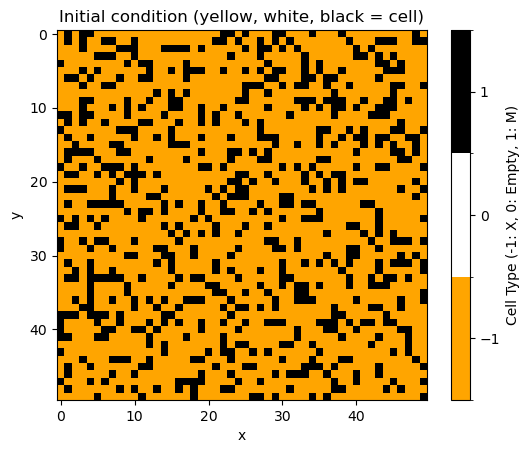

In [31]:
# Exercise 7: Plotting the results of our model of random division
plotcells(cellGrid)
# Setting up the animation
fig, axes = plt.subplots(figsize=(5,5))

# Defining our function to plot the results in an animation
def animate(frame):
  axes.clear()
  global cellGrid
  cellGrid = birth_cells(cellGrid)
  #cellGrid = death_cells(cellGrid)
  cellGrid = short_range(cellGrid)

  # Create a custom colormap
  colors = ['orange', 'white', 'black']
  cmap = matplotlib.colors.ListedColormap(colors)
  bounds = [-1.5, -0.5, 0.5, 1.5]
  norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
  axes.imshow(cellGrid,cmap=cmap, norm=norm)
  axes.set_xlabel("x")
  axes.set_ylabel("y")
  axes.set_title("Cell division (yellow = cell)")
  return axes,

# Simulating the model and plotting results
anim = FuncAnimation(fig, animate, interval=100, blit=False, frames=numSteps, repeat=False)
plt.close()
anim